<a href="https://colab.research.google.com/github/rileyhitthefan/bat-lab/blob/main/MLModel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 1) Mount Google Drive and set your data root
from google.colab import drive
drive.mount('/content/drive')

root_dir = "/content/drive/MyDrive/Bat Calls"
print("root_dir:", root_dir)

Mounted at /content/drive
root_dir: /content/drive/MyDrive/Bat Calls


In [ ]:
#@title 2) Install & Imports
!pip -q install librosa==0.10.2.post1 soundfile==0.12.1 pyyaml==6.0.2 tqdm==4.66.5 scikit-learn==1.5.2

import os, io, math, json, yaml, random, time, gc
from dataclasses import dataclass
from typing import Dict
import numpy as np
import pandas as pd
from tqdm import tqdm

import librosa, soundfile as sf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Torch:", torch.__version__, "| Device:", DEVICE)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 98.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.
dataproc-spark-connect 0.8.3 requires tqdm>=4.67, but you have tqdm 4.66.5 which is incompatible.
Torch: 2.8.0+cu126 | Device: cuda


In [ ]:
#@title 3) Configuration
CONFIG = {
    "sr": 48000,
    "mono": True,
    "duration_s": 1.0,
    "hop_length": 512,
    "n_fft": 1024,
    "n_mels": 128,
    "fmin": 1000,
    "fmax": 24000,
    "batch_size": 32,  # Increased from 16
    "num_workers": 2,
    "lr": 2e-4,  # Lower learning rate for stability
    "epochs": 25,  # More epochs
    "model_dir": "checkpoints",
    "cache_dir": "cache_mels",
    "numfeat_cache_dir": "cache_numfeats",
    "manifest_csv": "data_manifest.csv",
    "thresholds_yaml": "thresholds.yaml",
    "default_min_conf": 0.70,  # FIXED: More reasonable threshold
}
os.makedirs(CONFIG["model_dir"], exist_ok=True)
os.makedirs(CONFIG["cache_dir"], exist_ok=True)
os.makedirs(CONFIG["numfeat_cache_dir"], exist_ok=True)

SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if DEVICE == "cuda": torch.cuda.manual_seed_all(SEED)

print(json.dumps(CONFIG, indent=2))

{
  "sr": 48000,
  "mono": true,
  "duration_s": 1.0,
  "hop_length": 512,
  "n_fft": 1024,
  "n_mels": 128,
  "fmin": 1000,
  "fmax": 24000,
  "batch_size": 32,
  "num_workers": 2,
  "lr": 0.0002,
  "epochs": 25,
  "model_dir": "checkpoints",
  "cache_dir": "cache_mels",
  "numfeat_cache_dir": "cache_numfeats",
  "manifest_csv": "data_manifest.csv",
  "thresholds_yaml": "thresholds.yaml",
  "default_min_conf": 0.7
}


In [ ]:
#@title 4) Manifest helpers (filepath,label,location)

def infer_species_and_location(path: str, root_dir: str):
    """Extract species from folder structure."""
    path = path.replace("\\", "/")
    root_dir = root_dir.replace("\\", "/")

    if path.startswith(root_dir):
        rel_path = path[len(root_dir):].lstrip("/")
    else:
        rel_path = path

    parts = [p for p in rel_path.split("/") if p]

    if len(parts) >= 3:
        species = parts[0]
        location = parts[1]
    elif len(parts) >= 2:
        species = parts[0]
        location = "unknown"
    else:
        species = "unknown"
        location = "unknown"

    return species, location

def build_manifest_from_dir(root_dir: str, out_csv: str):
    rows = []
    for dirpath, _, filenames in os.walk(root_dir):
        for fn in filenames:
            if fn.lower().endswith(".wav"):
                full = os.path.join(dirpath, fn)
                label, location = infer_species_and_location(full, root_dir)
                rows.append({"filepath": full, "label": label, "location": location})

    df = pd.DataFrame(rows).sort_values("filepath")

    print(f"\n=== MANIFEST DIAGNOSTICS ===")
    print(f"Total files found: {len(df)}")
    print(f"\nSpecies distribution:")
    print(df['label'].value_counts())
    print(f"\nLocation distribution:")
    print(df['location'].value_counts())
    print(f"\nSample paths:")
    for i in range(min(3, len(df))):
        print(f"  {df.iloc[i]['filepath']}")
        print(f"  -> Species: {df.iloc[i]['label']}, Location: {df.iloc[i]['location']}")

    df.to_csv(out_csv, index=False)
    print(f"\nWrote {out_csv} with {len(df)} rows")
    return df

def load_manifest(csv_path: str):
    df = pd.read_csv(csv_path)
    assert {"filepath","label","location"}.issubset(df.columns)
    return df

# Build manifest
df = build_manifest_from_dir(root_dir, CONFIG["manifest_csv"])
print("\n=== FIRST 3 ROWS ===")
print(df.head(3))


=== MANIFEST DIAGNOSTICS ===
Total files found: 107

Species distribution:
label
TADAEG    25
RHICAP    21
TAPMAU    15
MYOTRI    11
SCOVIR    10
NYCTHE     8
SCODIN     7
OTOMAR     7
NEOCAP     2
MINNAT     1
Name: count, dtype: int64

Location distribution:
location
unknown    107
Name: count, dtype: int64

Sample paths:
  /content/drive/MyDrive/Bat Calls/MINNAT/00277_NEOCAP_24F3190166BC0811_20250603_180754_000T.wav
  -> Species: MINNAT, Location: unknown
  /content/drive/MyDrive/Bat Calls/MYOTRI/00001_NEOCAP_24F3190166BC0811_20250603_182636_000T.wav
  -> Species: MYOTRI, Location: unknown
  /content/drive/MyDrive/Bat Calls/MYOTRI/00003_MINNAT_24F3190166BC0811_20250530_181318_000T.wav
  -> Species: MYOTRI, Location: unknown

Wrote data_manifest.csv with 107 rows

=== FIRST 3 ROWS ===
                                              filepath   label location
106  /content/drive/MyDrive/Bat Calls/MINNAT/00277_...  MINNAT  unknown
86   /content/drive/MyDrive/Bat Calls/MYOTRI/00001_...  M

In [ ]:
#@title 5) Audio Processing Functions

def load_wav_fixed(path, sr, mono, duration_s):
    y, s = librosa.load(path, sr=sr, mono=mono)
    target_len = int(sr*duration_s)
    if len(y) < target_len:
        y = np.pad(y, (0, target_len-len(y)))
    elif len(y) > target_len:
        y = y[:target_len]
    return y, sr

def wav_to_mel(y, sr, n_fft, hop_length, n_mels, fmin, fmax):
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmin=fmin, fmax=fmax, power=2.0
    )
    S_db = librosa.power_to_db(S, ref=np.max)
    S_min, S_max = S_db.min(), S_db.max()
    S_norm = (S_db - S_min) / (S_max - S_min + 1e-8)
    return S_norm.astype(np.float32)

def cache_mel(path: str, root_dir_param: str, cfg: dict):
    """Cache mel spectrogram with proper path handling."""
    rel_path = path.replace(root_dir_param, "").replace("/", "_").replace("\\", "_")
    key = rel_path.replace(".wav", f"_{cfg['sr']}sr_{cfg['n_mels']}mels.npy")
    out_path = os.path.join(cfg["cache_dir"], key)

    if os.path.exists(out_path):
        return out_path

    y, sr = load_wav_fixed(path, cfg["sr"], cfg["mono"], cfg["duration_s"])
    mel = wav_to_mel(y, sr, cfg["n_fft"], cfg["hop_length"], cfg["n_mels"], cfg["fmin"], cfg["fmax"])
    np.save(out_path, mel)
    return out_path


In [ ]:
# 5a) Advanced Spectrogram Visualization with Ridge Detection
from scipy.signal import medfilt

def show_single_bat_call(
    wav_path,
    min_freq=20000,
    max_freq=90000,
    context_ms=3.0,
    n_fft=2048,
    hop_length=128,
    ridge_crop_khz=15,
    cmap="magma"
):
    """
    Visualize bat call with zoomed spectrogram and ridge overlay.
    """
    # Load
    y, sr = librosa.load(wav_path, sr=None, mono=True)
    if len(y) < 10:
        raise ValueError("Audio too short.")

    # Trim edges
    y, _ = librosa.effects.trim(y, top_db=25)

    # Pre-emphasis to boost HF
    y = librosa.effects.preemphasis(y, coef=0.97)

    # STFT
    S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    S_mag = np.abs(S)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    times = librosa.frames_to_time(np.arange(S_mag.shape[1]), sr=sr, hop_length=hop_length)

    # Clamp max_freq to Nyquist
    nyq = sr / 2
    if max_freq > nyq:
        max_freq = nyq

    # HF band for detection
    band = (freqs >= min_freq) & (freqs <= max_freq)
    if not np.any(band):
        raise ValueError(f"No freq bins in [{min_freq}, {max_freq}] Hz for sr={sr}")

    band_mag = S_mag[band, :]

    # Detect call region by HF energy
    band_max = band_mag.max(axis=0)
    band_max_smooth = medfilt(band_max, kernel_size=7)

    med = np.median(band_max_smooth)
    peak = band_max_smooth.max()
    if peak <= 0:
        raise ValueError("No non-zero HF energy found.")

    alpha = 0.35
    thr = med + alpha * (peak - med)
    mask = band_max_smooth >= thr

    if not np.any(mask):
        center = int(np.argmax(band_max_smooth))
        start_idx = max(0, center - 5)
        end_idx   = min(S_mag.shape[1]-1, center + 5)
    else:
        idx = np.where(mask)[0]
        segments = []
        start = idx[0]
        prev = idx[0]
        for i in idx[1:]:
            if i == prev + 1:
                prev = i
            else:
                segments.append((start, prev))
                start = i
                prev = i
        segments.append((start, prev))

        best = max(segments, key=lambda seg: band_max_smooth[seg[0]:seg[1]+1].sum())
        start_idx, end_idx = best

    # Add context
    pad_frames = int((context_ms / 1000.0) * sr / hop_length)
    start_idx = max(0, start_idx - pad_frames)
    end_idx   = min(S_mag.shape[1]-1, end_idx + pad_frames)

    start_t = times[start_idx]
    end_t   = times[end_idx]

    # Crop to time window
    S_win = S_mag[:, start_idx:end_idx+1]
    times_win = times[start_idx:end_idx+1]

    # Vertical band
    band_disp = (freqs >= min_freq) & (freqs <= max_freq)
    S_band = S_win[band_disp, :]
    freqs_band = freqs[band_disp]

    # Find ridge
    ridge_idx = np.argmax(S_band, axis=0)
    ridge_freqs = freqs_band[ridge_idx]

    ridge_center_hz = np.median(ridge_freqs)
    crop_half = ridge_crop_khz * 1000.0

    f_low = max(min_freq, ridge_center_hz - crop_half)
    f_high = min(max_freq, ridge_center_hz + crop_half)

    tight_band = (freqs_band >= f_low) & (freqs_band <= f_high)
    S_tight = S_band[tight_band, :]
    freqs_tight = freqs_band[tight_band]

    S_db = librosa.amplitude_to_db(S_tight, ref=np.max)
    S_db = np.clip(S_db, S_db.max() - 60, S_db.max())

    # Plot
    plt.figure(figsize=(8, 4))

    extent = [
        times_win[0],
        times_win[-1],
        freqs_tight[0] / 1000.0,
        freqs_tight[-1] / 1000.0,
    ]
    plt.imshow(
        S_db,
        aspect="auto",
        origin="lower",
        extent=extent,
        cmap=cmap,
    )

    ridge_khz = ridge_freqs / 1000.0
    plt.plot(times_win, ridge_khz, linestyle="--", linewidth=1.2, color="white", alpha=0.9)

    plt.title(os.path.basename(wav_path) + " — Zoomed Bat Call Ridge")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (kHz)")
    cbar = plt.colorbar(format="%+2.0f dB")
    cbar.set_label("Amplitude (dB)")
    plt.tight_layout()
    plt.show()

    print(f"Zoomed time window: {start_t:.6f}–{end_t:.6f} s "
          f"(~{(end_t-start_t)*1000:.2f} ms)")
    print(f"Ridge center ≈ {ridge_center_hz/1000.0:.1f} kHz "
          f"(displayed ±{ridge_crop_khz} kHz)")


In [ ]:
#@title 5b) Numeric Feature Computation

NUMERIC_FEAT_NAMES = [
    "duration_sec",
    "rms_mean",
    "rms_std",
    "hf_centroid_hz",
    "hf_bandwidth_hz",
    "hf_peak_freq_hz",
    "zcr_mean",
    "zcr_std",
]
NUMERIC_FEAT_DIM = len(NUMERIC_FEAT_NAMES)

def compute_numeric_features_from_y(y: np.ndarray, sr: int, cfg: dict) -> np.ndarray:
    """Compute numeric descriptors of the call."""
    n_fft = cfg["n_fft"]
    hop = cfg["hop_length"]
    fmin = cfg["fmin"]
    fmax = cfg["fmax"]

    duration_sec = len(y) / float(sr)

    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop))
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    band_mask = (freqs >= fmin) & (freqs <= fmax)
    if band_mask.sum() == 0:
        S_band = S
        freqs_band = freqs
    else:
        S_band = S[band_mask, :]
        freqs_band = freqs[band_mask]

    power = S_band ** 2 + 1e-8
    mean_spec = power.mean(axis=1)
    spec_sum = mean_spec.sum()

    hf_centroid = float((freqs_band * mean_spec).sum() / spec_sum)
    hf_peak_freq = float(freqs_band[int(np.argmax(mean_spec))])
    hf_bandwidth = float(
        np.sqrt(((freqs_band - hf_centroid) ** 2 * mean_spec).sum() / spec_sum)
    )

    rms = np.sqrt(np.mean(S_band**2, axis=0))
    rms_mean = float(rms.mean())
    rms_std = float(rms.std() + 1e-8)

    zcr = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop)[0]
    zcr_mean = float(zcr.mean())
    zcr_std = float(zcr.std() + 1e-8)

    feats = np.array(
        [duration_sec, rms_mean, rms_std, hf_centroid, hf_bandwidth,
         hf_peak_freq, zcr_mean, zcr_std],
        dtype=np.float32,
    )
    return feats

def cache_numeric_features(path: str, root_dir_param: str, cfg: dict) -> str:
    """Cache numeric features."""
    rel_path = path.replace(root_dir_param, "").replace("/", "_").replace("\\", "_")
    key = rel_path.replace(".wav", f"_{cfg['sr']}sr_numfeat.npy")
    out_path = os.path.join(cfg["numfeat_cache_dir"], key)

    if os.path.exists(out_path):
        return out_path

    y, sr = load_wav_fixed(path, cfg["sr"], cfg["mono"], cfg["duration_s"])
    feats = compute_numeric_features_from_y(y, sr, cfg)
    np.save(out_path, feats.astype(np.float32))
    return out_path


In [ ]:
#@title 5c) Compute and Save Feature Normalization Stats

def compute_feature_stats(df: pd.DataFrame, root_dir_param: str, cfg: dict):
    """Compute mean and std for numeric features across training data."""
    print("\n=== Computing feature normalization statistics ===")
    all_feats = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Computing features"):
        feat_path = cache_numeric_features(row['filepath'], root_dir_param, cfg)
        feats = np.load(feat_path)
        all_feats.append(feats)

    all_feats = np.stack(all_feats, axis=0)  # [N, NUMERIC_FEAT_DIM]

    scaler = StandardScaler()
    scaler.fit(all_feats)

    # Save to config
    stats = {
        'mean': scaler.mean_.tolist(),
        'std': scaler.scale_.tolist(),
    }

    stats_path = os.path.join(cfg["model_dir"], "feature_stats.json")
    with open(stats_path, 'w') as f:
        json.dump(stats, f, indent=2)

    print(f"Feature stats saved to {stats_path}")
    print(f"Mean: {scaler.mean_}")
    print(f"Std: {scaler.scale_}")

    return scaler.mean_, scaler.scale_


In [ ]:
#@title 6) Dataset with Normalized Features

class BatDataset(Dataset):
    def __init__(self, df: pd.DataFrame, label_to_idx: Dict[str,int],
                 loc_to_idx: Dict[str,int], root_dir_param: str,
                 feat_mean: np.ndarray, feat_std: np.ndarray):
        self.df = df.reset_index(drop=True)
        self.label_to_idx = label_to_idx
        self.loc_to_idx = loc_to_idx
        self.root_dir = root_dir_param
        self.feat_mean = feat_mean
        self.feat_std = feat_std

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]

        # Mel spectrogram
        mel_path = cache_mel(row.filepath, self.root_dir, CONFIG)
        mel = np.load(mel_path)
        x = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)  # [1, n_mels, T]

        # Labels
        y = torch.tensor(self.label_to_idx[row.label], dtype=torch.long)
        loc = torch.tensor(self.loc_to_idx.get(row.location, 0), dtype=torch.long)

        # Numeric features (normalized)
        num_path = cache_numeric_features(row.filepath, self.root_dir, CONFIG)
        num_feats = np.load(num_path)
        num_feats = (num_feats - self.feat_mean) / (self.feat_std + 1e-8)  # Normalize
        num_feats = torch.tensor(num_feats, dtype=torch.float32)

        return x, y, loc, num_feats, row.filepath


In [ ]:
#@title 7) Model: CNN + Location + Numeric Features

class BatClassifier(nn.Module):
    """Unified model with mel spec, location, and numeric features."""
    def __init__(
        self,
        n_classes: int,
        n_locations: int,
        num_feat_dim: int,
        loc_embed_dim: int = 16,
        num_feat_hidden: int = 32,
        dropout: float = 0.3,
    ):
        super().__init__()

        # CNN for mel spectrogram
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(0.1),

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout2d(0.1),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        # Location embedding
        self.loc_embed = nn.Embedding(
            num_embeddings=max(1, n_locations),
            embedding_dim=loc_embed_dim,
        )

        # Numeric feature encoder
        self.num_fc = nn.Sequential(
            nn.Linear(num_feat_dim, num_feat_hidden),
            nn.BatchNorm1d(num_feat_hidden),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
        )

        # Combined classifier
        combined_dim = 128 * 4 * 4 + loc_embed_dim + num_feat_hidden

        self.fc = nn.Sequential(
            nn.Linear(combined_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, n_classes),
        )

        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, x, loc_ids, num_feats):
        z = self.conv(x).flatten(1)
        le = self.loc_embed(loc_ids)
        nf = self.num_fc(num_feats)

        combined = torch.cat([z, le, nf], dim=1)
        logits = self.fc(combined)
        logits = logits / self.temperature.clamp_min(0.5)
        return logits



In [ ]:
#@title 8) Training Functions

@dataclass
class TrainResult:
    best_path: str
    history: list

def accuracy(logits, y):
    preds = logits.argmax(1)
    return (preds == y).float().mean().item()

def run_epoch(model, loader, opt=None):
    is_train = opt is not None
    model.train() if is_train else model.eval()
    total_loss, total_acc, total_n = 0.0, 0.0, 0

    pbar = tqdm(loader, desc="Training" if is_train else "Validating", leave=False)
    for x, y, loc, num_feats, _ in pbar:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        loc = loc.to(DEVICE)
        num_feats = num_feats.to(DEVICE)

        with torch.set_grad_enabled(is_train):
            logits = model(x, loc, num_feats)
            loss = F.cross_entropy(logits, y)

            if is_train:
                opt.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
                opt.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy(logits, y) * bs
        total_n    += bs

        pbar.set_postfix({
            "loss": f"{total_loss/total_n:.4f}",
            "acc": f"{total_acc/total_n:.3f}"
        })

    return {"loss": total_loss / total_n, "acc": total_acc / total_n}

def train_model(loaders, meta, feat_mean, feat_std):
    meta = dict(meta)
    meta["numeric_feat_dim"] = NUMERIC_FEAT_DIM
    meta["feat_mean"] = feat_mean.tolist()
    meta["feat_std"] = feat_std.tolist()

    model = BatClassifier(
        n_classes=len(meta["species"]),
        n_locations=len(meta["locations"]),
        num_feat_dim=NUMERIC_FEAT_DIM,
    ).to(DEVICE)

    opt = torch.optim.AdamW(model.parameters(), lr=CONFIG["lr"], weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        opt, mode="max", factor=0.5, patience=3
    )

    best_val, history = 0.0, []
    best_path = os.path.join(CONFIG["model_dir"], "best_model.pt")
    patience_counter = 0
    early_stop_patience = 7

    print("\n=== TRAINING MODEL ===")
    print(f"Classes: {len(meta["species"])}")
    print(f"Species: {meta['species']}")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    for epoch in range(1, CONFIG["epochs"] + 1):
        tr = run_epoch(model, loaders["train"], opt)
        va = run_epoch(model, loaders["val"], None)
        scheduler.step(va["acc"])

        history.append({"epoch": epoch, "train": tr, "val": va})
        print(
            f"Epoch {epoch:02d} | "
            f"train {tr['loss']:.4f}/{tr['acc']:.3f} | "
            f"val {va['loss']:.4f}/{va['acc']:.3f} | "
            f"lr {opt.param_groups[0]['lr']:.6f}"
        )

        if va["acc"] > best_val:
            best_val = va["acc"]
            patience_counter = 0
            torch.save({"model_state": model.state_dict(), "meta": meta}, best_path)
            print(f"  ✓ New best model saved (val_acc={best_val:.3f})")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print(f"\nEarly stopping triggered after {epoch} epochs")
                break

    return TrainResult(best_path=best_path, history=history)

def evaluate_model(model, loader):
    model.eval()
    total_acc, total_n = 0.0, 0
    with torch.no_grad():
        for x, y, loc, num_feats, _ in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            loc = loc.to(DEVICE)
            num_feats = num_feats.to(DEVICE)

            logits = model(x, loc, num_feats)
            total_acc += accuracy(logits, y) * x.size(0)
            total_n   += x.size(0)
    return total_acc / total_n if total_n > 0 else 0.0


In [ ]:
#@title 9) Temperature Calibration

def calibrate_temperature(model, loader, max_iters=200, lr=5e-2):
    model.eval()
    temp = model.temperature
    opt = torch.optim.LBFGS([temp], lr=lr, max_iter=max_iters)

    def _nll():
        losses = []
        for x, y, loc, num_feats, _ in loader:
            x, y, loc, num_feats = (
                x.to(DEVICE), y.to(DEVICE),
                loc.to(DEVICE), num_feats.to(DEVICE)
            )
            loss = F.cross_entropy(model(x, loc, num_feats), y)
            losses.append(loss)
        return torch.stack(losses).mean()

    def closure():
        opt.zero_grad()
        loss = _nll()
        loss.backward()
        return loss

    before = _nll().item()
    opt.step(closure)
    after = _nll().item()
    print(f"Calibration NLL: {before:.4f} -> {after:.4f}; T={temp.item():.3f}")
    return temp.item()


In [ ]:
#@title 10) Inference Functions

def load_thresholds(path: str, default_min_conf: float):
    if os.path.exists(path):
        with open(path, "r") as f:
            th = yaml.safe_load(f) or {}
    else:
        th = {}
    th["_default_min_conf"] = th.get("_default_min_conf", default_min_conf)
    return th

def get_min_conf(thresholds: dict, species: str, location: str):
    per = thresholds.get("per", {})
    default = thresholds.get("_default_min_conf", CONFIG["default_min_conf"])
    if species in per and location in per[species]:
        return float(per[species][location])
    return float(default)

def load_best(model_path: str):
    ckpt = torch.load(model_path, map_location=DEVICE)
    meta = ckpt["meta"]
    num_dim = meta.get("numeric_feat_dim", NUMERIC_FEAT_DIM)

    model = BatClassifier(
        n_classes=len(meta["species"]),
        n_locations=len(meta["locations"]),
        num_feat_dim=num_dim,
    ).to(DEVICE)
    model.load_state_dict(ckpt["model_state"])
    model.eval()
    return model, meta

@torch.no_grad()
def predict_batch(model, batch_x, batch_loc, batch_num, meta, thresholds):
    model.eval()
    logits = model(
        batch_x.to(DEVICE),
        batch_loc.to(DEVICE),
        batch_num.to(DEVICE),
    )
    probs = F.softmax(logits, dim=1).cpu().numpy()
    preds = probs.argmax(1)

    out = []
    idx_to_label = {v: k for k, v in meta["label_to_idx"].items()}
    idx_to_loc   = {v: k for k, v in meta["loc_to_idx"].items()}

    for i in range(len(preds)):
        top_idx = int(preds[i])
        top_label = idx_to_label[top_idx]
        p = float(probs[i, top_idx])

        loc_name = idx_to_loc[int(batch_loc[i].cpu().item())]
        min_conf = get_min_conf(thresholds, top_label, loc_name)
        is_unknown = (p < min_conf)
        reasons = (
            [{"type": "low_conf", "top1_conf": p, "min_conf": min_conf}]
            if is_unknown else []
        )
        out.append({
            "label": top_label,
            "prob": p,
            "location": loc_name,
            "is_unknown": is_unknown,
            "reasons": reasons,
        })
    return out


In [ ]:
#@title 11) Prepare Data and Train

# Filter classes with insufficient samples
label_counts = df['label'].value_counts()
labels_to_keep = label_counts[label_counts >= 3].index
df_filtered = df[df['label'].isin(labels_to_keep)]

print(f"\n=== DATA FILTERING ===")
print(f"Original samples: {len(df)}")
print(f"Filtered samples: {len(df_filtered)}")
print(f"Classes kept: {len(labels_to_keep)}")

# Create mappings
species_names = sorted(df_filtered['label'].unique())
label_to_idx = {name: i for i, name in enumerate(species_names)}

location_names = sorted(df_filtered['location'].unique())
loc_to_idx = {name: i for i, name in enumerate(location_names)}

# Split data
train_df, test_val_df = train_test_split(
    df_filtered, test_size=0.3, stratify=df_filtered['label'], random_state=SEED
)
val_df, test_df = train_test_split(
    test_val_df, test_size=0.5, stratify=test_val_df['label'], random_state=SEED
)

print(f"\nTrain: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# Compute feature normalization stats on training data only
feat_mean, feat_std = compute_feature_stats(train_df, root_dir, CONFIG)

# Create datasets with normalized features
train_ds = BatDataset(train_df, label_to_idx, loc_to_idx, root_dir, feat_mean, feat_std)
val_ds   = BatDataset(val_df, label_to_idx, loc_to_idx, root_dir, feat_mean, feat_std)
test_ds  = BatDataset(test_df, label_to_idx, loc_to_idx, root_dir, feat_mean, feat_std)

# Create DataLoaders
loaders = {
    "train": DataLoader(train_ds, batch_size=CONFIG["batch_size"],
                       shuffle=True, num_workers=CONFIG["num_workers"], pin_memory=True),
    "val": DataLoader(val_ds, batch_size=CONFIG["batch_size"],
                     shuffle=False, num_workers=CONFIG["num_workers"], pin_memory=True),
    "test": DataLoader(test_ds, batch_size=CONFIG["batch_size"],
                      shuffle=False, num_workers=CONFIG["num_workers"], pin_memory=True),
}

meta = {
    "species": species_names,
    "label_to_idx": label_to_idx,
    "locations": location_names,
    "loc_to_idx": loc_to_idx,
}

# Train
result = train_model(loaders, meta, feat_mean, feat_std)
print(f"\nBest checkpoint: {result.best_path}")

# Calibrate
best_model, _meta = load_best(result.best_path)
_ = calibrate_temperature(best_model, loaders["val"])
torch.save({"model_state": best_model.state_dict(), "meta": _meta}, result.best_path)

# Evaluate
test_acc = evaluate_model(best_model, loaders["test"])
print(f"\n=== FINAL TEST ACCURACY: {test_acc:.3f} ===")


=== DATA FILTERING ===
Original samples: 107
Filtered samples: 104
Classes kept: 8

Train: 72 | Val: 16 | Test: 16

=== Computing feature normalization statistics ===


Computing features: 100%|██████████| 72/72 [02:17<00:00,  1.91s/it]


Feature stats saved to checkpoints/feature_stats.json
Mean: [1.00000000e+00 7.12234121e-02 5.57956871e-02 1.45534184e+04
 4.33810354e+03 1.54505208e+04 2.95569165e-01 6.88620856e-02]
Std: [1.00000000e+00 7.66413612e-02 9.08656818e-02 5.07994800e+03
 1.23270938e+03 7.54676806e+03 2.73433074e-01 5.90392986e-02]

=== TRAINING MODEL ===
Classes: 8
Species: ['MYOTRI', 'NYCTHE', 'OTOMAR', 'RHICAP', 'SCODIN', 'SCOVIR', 'TADAEG', 'TAPMAU']
Model parameters: 665,017


Epoch 01 | train 2.1497/0.097 | val 2.0744/0.062 | lr 0.000200
  ✓ New best model saved (val_acc=0.062)


Epoch 02 | train 1.9498/0.181 | val 2.0616/0.125 | lr 0.000200
  ✓ New best model saved (val_acc=0.125)


Epoch 03 | train 1.8302/0.333 | val 2.0433/0.250 | lr 0.000200
  ✓ New best model saved (val_acc=0.250)


Epoch 04 | train 1.6477/0.444 | val 2.0214/0.250 | lr 0.000200


Epoch 05 | train 1.5879/0.514 | val 1.9989/0.250 | lr 0.000200


Epoch 06 | train 1.7080/0.333 | val 1.9826/0.250 | lr 0.000200


Epoch 07 | train 1.4903/0.514 | val 1.9724/0.250 | lr 0.000100


Epoch 08 | train 1.4178/0.542 | val 1.9663/0.250 | lr 0.000100


Epoch 09 | train 1.4600/0.528 | val 1.9613/0.250 | lr 0.000100


Epoch 10 | train 1.4745/0.500 | val 1.9451/0.250 | lr 0.000100

Early stopping triggered after 10 epochs

Best checkpoint: checkpoints/best_model.pt


/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


Calibration NLL: 2.0433 -> 2.0149; T=0.499

=== FINAL TEST ACCURACY: 0.250 ===


In [ ]:
#@title 12) Save Thresholds

example_thresholds = {
    "_default_min_conf": 0.70,
    "per": {}
}
with open(CONFIG["thresholds_yaml"], "w") as f:
    yaml.safe_dump(example_thresholds, f)
print(f"Wrote {CONFIG['thresholds_yaml']}")


Wrote thresholds.yaml


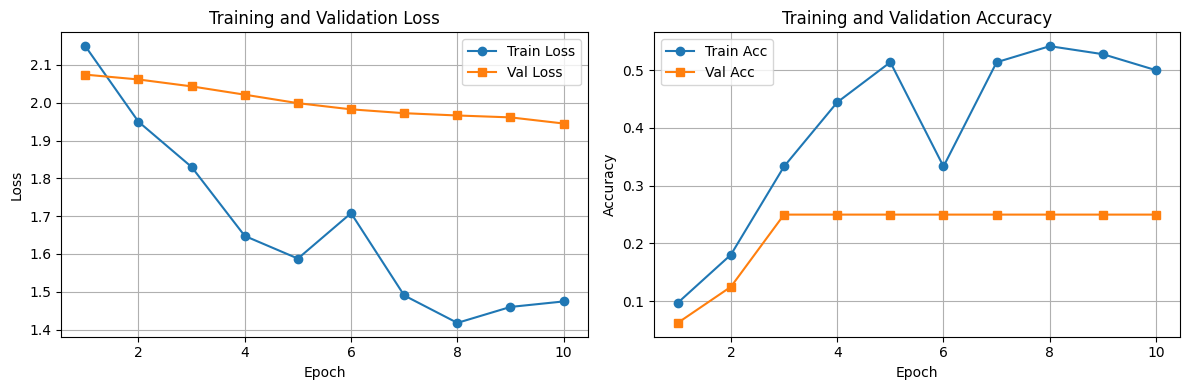

In [ ]:
#@title 13) Visualize Training History

def plot_training_history(history):
    epochs = [h['epoch'] for h in history]
    train_loss = [h['train']['loss'] for h in history]
    train_acc = [h['train']['acc'] for h in history]
    val_loss = [h['val']['loss'] for h in history]
    val_acc = [h['val']['acc'] for h in history]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(epochs, train_loss, label='Train Loss', marker='o')
    ax1.plot(epochs, val_loss, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, train_acc, label='Train Acc', marker='o')
    ax2.plot(epochs, val_acc, label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(result.history)



=== SINGLE FILE PREDICTION ===
File: 00277_NEOCAP_24F3190166BC0811_20250603_180754_000T.wav

Spectrogram visualization:


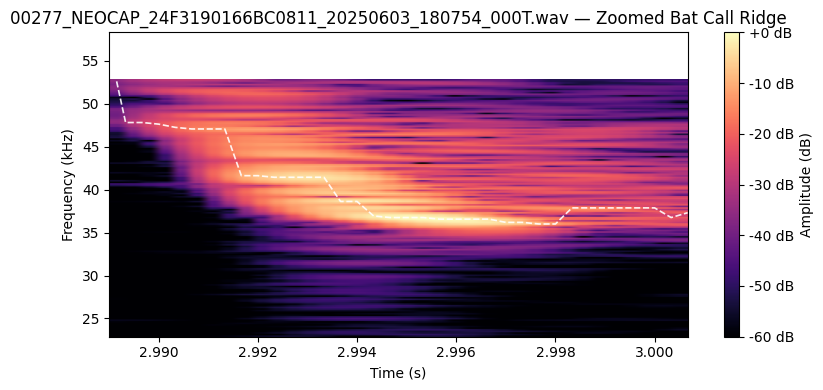

Zoomed time window: 2.989000–3.000667 s (~11.67 ms)
Ridge center ≈ 37.9 kHz (displayed ±15 kHz)


In [ ]:
#@title 14) Single File Prediction with Visualization

# Get a test file
test_wav = df['filepath'].iloc[0]
loc_name = "unknown" if "unknown" in meta["locations"] else meta["locations"][0]

print("\n=== SINGLE FILE PREDICTION ===")
print(f"File: {os.path.basename(test_wav)}")

# Make prediction (you'll need to implement predict_file for the new model)
# For now, let's just visualize the spectrogram
print("\nSpectrogram visualization:")
show_single_bat_call(test_wav, min_freq=20000, max_freq=90000)



Testing: 100%|██████████| 1/1 [00:00<00:00, 11.12it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(res


Wrote: test_predictions.csv

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      MYOTRI       0.00      0.00      0.00         1
      NYCTHE       0.00      0.00      0.00         1
      OTOMAR       0.00      0.00      0.00         1
      RHICAP       0.00      0.00      0.00         4
      SCODIN       0.00      0.00      0.00         1
      SCOVIR       0.00      0.00      0.00         1
      TADAEG       0.25      1.00      0.40         4
      TAPMAU       0.00      0.00      0.00         3

    accuracy                           0.25        16
   macro avg       0.03      0.12      0.05        16
weighted avg       0.06      0.25      0.10        16


=== CONFUSION MATRIX ===


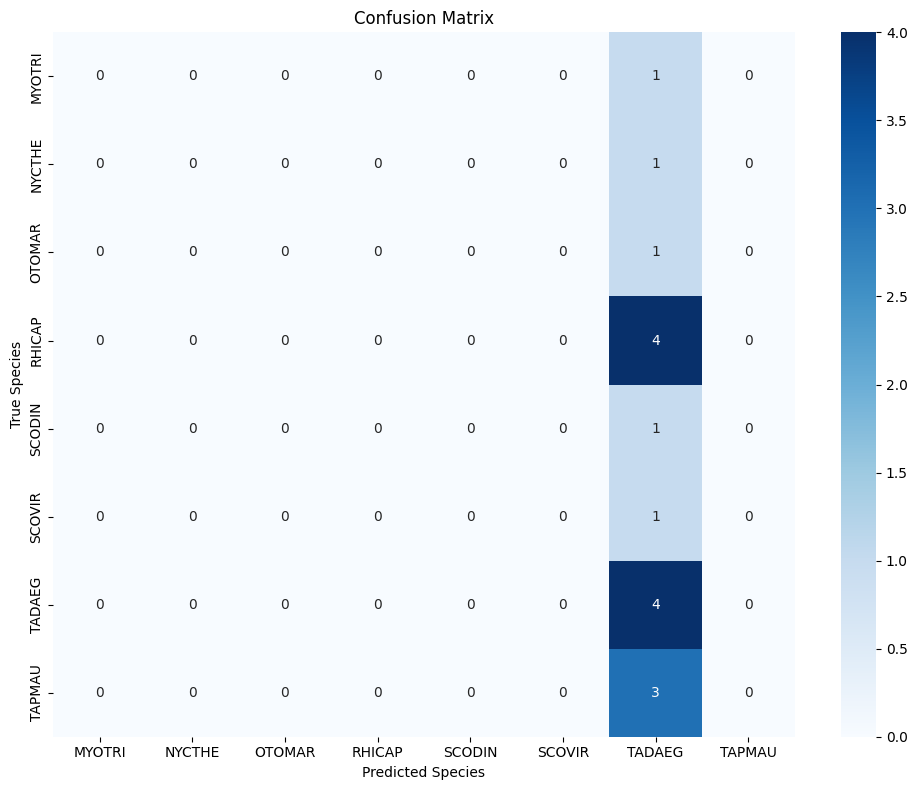


=== PER-CLASS ACCURACY ===
true_label
TADAEG    1.0
MYOTRI    0.0
OTOMAR    0.0
NYCTHE    0.0
RHICAP    0.0
SCODIN    0.0
SCOVIR    0.0
TAPMAU    0.0
Name: correct, dtype: float64

=== SAMPLE PREDICTIONS ===
                                            filepath true_label pred_label  \
0  /content/drive/MyDrive/Bat Calls/SCODIN/00483_...     SCODIN     TADAEG   
1  /content/drive/MyDrive/Bat Calls/MYOTRI/00489_...     MYOTRI     TADAEG   
2  /content/drive/MyDrive/Bat Calls/TAPMAU/00262_...     TAPMAU     TADAEG   
3  /content/drive/MyDrive/Bat Calls/RHICAP/00065_...     RHICAP     TADAEG   
4  /content/drive/MyDrive/Bat Calls/SCOVIR/00323_...     SCOVIR     TADAEG   
5  /content/drive/MyDrive/Bat Calls/TADAEG/00019_...     TADAEG     TADAEG   
6  /content/drive/MyDrive/Bat Calls/TADAEG/00010_...     TADAEG     TADAEG   
7  /content/drive/MyDrive/Bat Calls/TAPMAU/00190_...     TAPMAU     TADAEG   
8  /content/drive/MyDrive/Bat Calls/RHICAP/00055_...     RHICAP     TADAEG   
9  /content

In [ ]:
#@title 15) Batch Test Set Evaluation with Confusion Matrix

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model_best, meta2 = load_best(result.best_path)
idx_to_label = {v:k for k,v in meta2["label_to_idx"].items()}
idx_to_loc   = {v:k for k,v in meta2["loc_to_idx"].items()}
thresholds = load_thresholds(CONFIG["thresholds_yaml"], CONFIG["default_min_conf"])

rows = []
all_true = []
all_pred = []

model_best.eval()
with torch.no_grad():
    for x, y, loc, num_feats, paths in tqdm(loaders["test"], desc="Testing"):
        x = x.to(DEVICE)
        loc = loc.to(DEVICE)
        num_feats = num_feats.to(DEVICE)
        logits = model_best(x, loc, num_feats)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        y = y.numpy()
        loc = loc.cpu().numpy()

        for i in range(len(paths)):
            top_idx = int(np.argmax(probs[i]))
            top_label = idx_to_label[top_idx]
            true_label = idx_to_label[int(y[i])]
            p = float(probs[i, top_idx])
            loc_name = idx_to_loc[int(loc[i])]
            min_conf = get_min_conf(thresholds, top_label, loc_name)
            is_unknown = p < min_conf

            all_true.append(true_label)
            all_pred.append(top_label)

            rows.append({
                "filepath": paths[i],
                "true_label": true_label,
                "pred_label": top_label,
                "pred_prob": round(p, 4),
                "location": loc_name,
                "is_unknown": is_unknown,
                "correct": true_label == top_label
            })

out_csv = "test_predictions.csv"
results_df = pd.DataFrame(rows)
results_df.to_csv(out_csv, index=False)
print(f"\nWrote: {out_csv}")

# Print classification report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(all_true, all_pred))

# Plot confusion matrix
print("\n=== CONFUSION MATRIX ===")
cm = confusion_matrix(all_true, all_pred, labels=meta2["species"])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=meta2["species"],
            yticklabels=meta2["species"])
plt.title('Confusion Matrix')
plt.ylabel('True Species')
plt.xlabel('Predicted Species')
plt.tight_layout()
plt.show()

# Show per-class accuracy
print("\n=== PER-CLASS ACCURACY ===")
class_acc = results_df.groupby('true_label')['correct'].mean()
print(class_acc.sort_values(ascending=False))

print("\n=== SAMPLE PREDICTIONS ===")
print(results_df.head(10))

